In [1]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import re
from functools import reduce
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
stocks_df = pd.read_csv("C:/Users/CMert/Documents/Data bachelorprojekt/complete_stock_df.csv")

In [3]:
stock_names = stocks_df["Symbol"].unique().tolist()

In [ ]:
# Function to convert strings to numerical values.
def convert_value(value):
    
    value = value.strip()
    
    if value.upper() == "N/A":
        return 696969
    
    if '%' in value:
        value_clean = value.replace('%', '').replace(',', '').strip()
        try:
            return float(value_clean) / 100
        except ValueError:
            print(f"Following percentage value caused error: '{value}'")
            return None
    
    else:
        value_clean = value.replace('$', '').replace(',', '').strip().upper()

        match = re.match(r'^(-?[\d\.]+)\s*(M|B|T|MILLION|BILLION|TRILLION)?$', value_clean)

        if match:
            number = float(match.group(1))
            suffix = match.group(2)
            if suffix in ('M', 'MILLION'):
                return number * 1e6
            elif suffix in ('B', 'BILLION'):
                return number * 1e9
            elif suffix in ('T', 'TRILLION'):
                return number * 1e12
            else:
                return number

In [ ]:
# Function to ensure all year-values are a 4 digit number.
def extract_year(value):
    match = re.search(r'\b(19|20)\d{2}\b', value)
    if match:
        return int(match.group(0))
    else:
        print(f"Could not extract year from value: '{value}'")
        return None

In [ ]:
def webscrape_func(list_of_stocks):
    
    service = Service(executable_path="chromedriver.exe")
    driver = webdriver.Chrome(service=service)
    
    driver.get("https://companiesmarketcap.com/")
    
    total_df_each_stock = []
    
    target_directory = 'indiv_stock_scraped'  
    os.makedirs(target_directory, exist_ok=True)
    
    def table_scrape(list_of_each_stock_sub_df):
       
        years = []
        stock_var = []

        try:
            first_table = driver.find_element(By.CLASS_NAME, "table")
            market_history = first_table.find_elements(By.TAG_NAME, 'tr')

            if not market_history:
                print("No table rows found.")
                return

            header_row = market_history[0]
            header_elements = header_row.find_elements(By.TAG_NAME, 'th')

            if len(header_elements) < 2:
                print("Insufficient header columns.")
                return

            headers = [element.text.strip() for element in header_elements[:2]]

            for row in market_history[1:]:
                elements = row.find_elements(By.TAG_NAME, 'td')

                if len(elements) < 2:
                    continue

                year = elements[0].text.strip()
                var = elements[1].text.strip()

                years.append(year)
                stock_var.append(var)

         
            years_cap_numeric = [extract_year(year) for year in years]
            stock_var_numeric = [convert_value(var) for var in stock_var]

            data = {
                headers[0]: years_cap_numeric,
                headers[1]: stock_var_numeric
            }

            df = pd.DataFrame(data)
            # Remove rows where the variable value is 696969. This is the way to deal with "N/A"-values in convert_value function
            df_cleaned = df[df[headers[1]] != 696969]
            
           
            df_cleaned = df_cleaned.sort_values(by='Year', ascending=True).reset_index(drop=True)
            list_of_each_stock_sub_df.append(df_cleaned)

            time.sleep(0.5)
        
        except Exception as e:
            print(f"Error during table scraping: {e}")
            return


    for stock in list_of_stocks:
        try:
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.ID, "search-input"))
            )

            input_element = driver.find_element(By.ID, "search-input")
            input_element.clear()
            input_element.send_keys(f"{stock}")  

            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.ID, "typeahead-search-results"))
            )
            search_stock = driver.find_element(By.ID, "typeahead-search-results")

            time.sleep(1)  
            first_link = search_stock.find_element(By.TAG_NAME, 'a')
            first_link.click()

            # This is to verify that the current stock matches with teh one on the website
            try:
                # Wait until the company-code div is present
                time.sleep(0.5)
                company_code_div = driver.find_element(By.CLASS_NAME, "company-code")
                company_code = company_code_div.text.strip()

                if company_code.upper() != stock.upper():
                    print(f"Skipping stock {stock} because company code does not match: {company_code}")
                    continue 
            except Exception as symbol_error:
                print(f"Error verifying company code for stock {stock}: {symbol_error}")
                print(f"Skipping stock {stock} due to symbol verification failure.")
                continue  

           
            list_of_each_stock_sub_df = []

            # Define the buttons to click
            buttons = [1, 2, 3, 5, 6, 7, 8, 12, 15, 16, 17, 18, 19]

            for button in buttons:
                try:
                    time.sleep(0.4)  
                    
                    if button < 6:
                        
                        next_button = driver.find_element(By.XPATH, f'//*[@id="cmkt"]/div[3]/ul/li[{button}]/a')
                        next_button.click()
                        table_scrape(list_of_each_stock_sub_df)
                    
                    elif button == 6:
                        
                        next_button = driver.find_element(By.XPATH, f'//*[@id="cmkt"]/div[3]/ul/li[{button}]/a')
                        next_button.click()
                        
                        more_button = driver.find_element(By.XPATH, '//*[@id="cmkt"]/div[3]/ul/li[7]/a')
                        more_button.click()
                        
                        
                        next_button = driver.find_element(By.XPATH, '//*[@id="cmkt"]/div[3]/ul/li[7]/div/a[3]')
                        next_button.click()
                        
                        table_scrape(list_of_each_stock_sub_df)
                    
                    else:
                        # Define variables inside the "more"-button
                        more_variables = {
                            7: "Operating Margin",
                            8: "EPS",
                            12: "Shares outstanding",
                            15: "Total assets",
                            16: "Total liabilities",
                            17: "Total debt",
                            18: "Cash on Hand",
                            19: "Net Assets"
                        }
                        
                        
                        more_button = driver.find_element(By.LINK_TEXT, "More")
                        more_button.click()
                        
                       
                        metric = more_variables.get(button)
                        if metric:
                            next_button = driver.find_element(By.LINK_TEXT, metric)
                            next_button.click()
                            table_scrape(list_of_each_stock_sub_df)
                        else:
                            print(f"No mapping found for button {button}. Skipping.")
                            continue

                except Exception as button_error:
                    print(f"Error processing button {button} for stock {stock}: {button_error}")
                    continue  

            # After clicking all buttons, merge the scraped tables for the current stock
            if list_of_each_stock_sub_df:
                try:
                    combined_df = reduce(
                        lambda left, right: pd.merge(left, right, on='Year', how='outer'),
                        list_of_each_stock_sub_df
                    )
                    combined_df["Symbol"] = stock
                    
                    # Ensure the number of columns matches number of buttons
                    expected_columns = len(buttons) + 2  # 'Year' and 'Symbol' plus one column per button
                    actual_columns = combined_df.shape[1]
                    if actual_columns != expected_columns:
                        print(f"Skipping stock {stock} due to unexpected number of columns: {actual_columns} (expected {expected_columns})")
                        continue  # Skip to the next stock
                    
                    # Save the individual stock DataFrame as CSV
                    filename = f"{stock}.csv" 
                    file_path = os.path.join(target_directory, filename)
                    combined_df.to_csv(file_path, index=False)
                    print(f"Saved {stock} data to {file_path}")
                    
                    
                    total_df_each_stock.append(combined_df)
                    
                except Exception as merge_error:
                    print(f"Error merging DataFrames for stock {stock}: {merge_error}")
                    continue  
            else:
                print(f"No data scraped for stock {stock}.")

            time.sleep(0.5)  

        except Exception as stock_error:
            print(f"Error processing stock {stock}: {stock_error}")
            continue  

    
    if total_df_each_stock:
        try:
            final_df = pd.concat(total_df_each_stock, ignore_index=True)
            final_df.to_csv("final_df_scraped_nr_11.csv", index=False)     # <----------- Change name
            print("Final DataFrame saved as 'final_df_scraped.csv'")
        except Exception as concat_error:
            print(f"Error concatenating DataFrames: {concat_error}")
    else:
        print("No DataFrames to concatenate. 'final_df_scraped.csv' not created.")
    
    
    driver.quit()

In [70]:
webscrape_func(stock_names[6020:])

Saved VYNE data to indiv_stock_scraped\VYNE.csv
Saved VYX data to indiv_stock_scraped\VYX.csv
Saved VZ data to indiv_stock_scraped\VZ.csv
Error processing button 17 for stock VZIO: Message: no such element: Unable to locate element: {"method":"link text","selector":"Total debt"}
  (Session info: chrome=129.0.6668.90); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7984DB125+29573]
	(No symbol) [0x00007FF79844FF50]
	(No symbol) [0x00007FF79830B6EA]
	(No symbol) [0x00007FF79835F815]
	(No symbol) [0x00007FF79835FA6C]
	(No symbol) [0x00007FF7983AB917]
	(No symbol) [0x00007FF79838733F]
	(No symbol) [0x00007FF7983A86BC]
	(No symbol) [0x00007FF7983870A3]
	(No symbol) [0x00007FF7983512DF]
	(No symbol) [0x00007FF798352441]
	GetHandleVerifier [0x00007FF79880C76D+3377613]
	GetHandleVerifier [0x00007FF798857B67+3685831]
	GetHandleVerifier [0x00007FF79884CF8B+36

In [16]:
# Combine all final dfs to have the final product
path = "C:/Users/CMert/Documents/Data bachelorprojekt/non_combined_final_dfs/final_df_scraped_nr_"
dfs = []

for i in range(1, 12):
    file_path = f"{path}{i}.csv"
    df = pd.read_csv(file_path)
    
    # Check if 'Operating Margin_x' and 'Operating Margin_y' exist and drop them
    columns_to_drop = ['Operating Margin_x', 'Operating Margin_y']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1)
    
    dfs.append(df)



final_df_scraped = pd.concat(dfs, ignore_index=True)

final_df_scraped.to_csv("C:/Users/CMert/Documents/Data bachelorprojekt/final_df_scraped.csv", index=False)


In [11]:
final_df_scraped.rename(columns={'Market cap': 'Market capitalization'}, inplace=True)

final_df_scraped.to_csv("C:/Users/CMert/Documents/Data bachelorprojekt/final_df_scraped.csv", index=False)

In [23]:
final_df_scraped = pd.read_csv("C:/Users/CMert/Documents/Data bachelorprojekt/final_df_scraped.csv")

final_df_scraped

,Year,Market capitalization,Revenue,Earnings,P/E ratio,P/B ratio,Operating Margin,EPS,Shares Outstanding,Total assets,Total liabilities,Total debt,Cash on Hand,Net assets,Symbol
0,1999,3.440000e+10,8.790000e+09,-8.500000e+08,NaN,NaN,NaN,1.350000,NaN,NaN,NaN,NaN,NaN,NaN,A
1,2000,2.498000e+10,1.070000e+10,1.190000e+09,NaN,NaN,NaN,1.680000,NaN,NaN,NaN,1.100000e+08,9.900000e+08,NaN,A
2,2001,1.321000e+10,7.310000e+09,-1.180000e+09,40.00,NaN,-0.0568,0.510000,NaN,7.980000e+09,2.320000e+09,6.000000e+06,1.170000e+09,5.650000e+09,A
3,2002,8.380000e+09,5.990000e+09,-1.380000e+09,-5.76,1.81,-0.2574,-2.230000,NaN,8.200000e+09,3.570000e+09,1.150000e+09,1.840000e+09,4.620000e+09,A
4,2003,1.392000e+10,6.280000e+09,-3.600000e+08,-4.83,4.93,-0.1558,-4.330000,NaN,6.290000e+09,3.470000e+09,1.150000e+09,1.600000e+09,2.820000e+09,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77847,2024,2.400000e+08,1.900000e+08,1.034000e+07,NaN,NaN,NaN,NaN,31760000.0,NaN,NaN,NaN,NaN,NaN,ZYXI
77848,1998,NaN,1.000000e+04,-2.000000e+04,NaN,NaN,NaN,-0.000474,NaN,NaN,NaN,NaN,NaN,NaN,ZYXI
77849,1999,NaN,1.600000e+05,5.000000e+04,NaN,NaN,NaN,-0.000912,NaN,NaN,NaN,NaN,NaN,NaN,ZYXI
77850,2000,NaN,2.100000e+05,-1.390000e+06,NaN,NaN,NaN,-602.740000,NaN,NaN,NaN,8.200000e+05,NaN,NaN,ZYXI


In [18]:
final_df_yf = pd.read_csv("C:/Users/CMert/Documents/Data bachelorprojekt/complete_stock_df.csv")

final_df_yf

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Sector,Industry,Symbol
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,26.603025,62546380.0,0.0,0.0,Industrials,Biotechnology: Laboratory Analytical Instruments,A
1,1999-11-19,30.713518,30.758226,28.478184,28.880545,24.411301,15234146.0,0.0,0.0,Industrials,Biotechnology: Laboratory Analytical Instruments,A
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,26.603025,6577870.0,0.0,0.0,Industrials,Biotechnology: Laboratory Analytical Instruments,A
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.184568,5975611.0,0.0,0.0,Industrials,Biotechnology: Laboratory Analytical Instruments,A
4,1999-11-24,28.701717,29.998213,28.612303,29.372318,24.826971,4843231.0,0.0,0.0,Industrials,Biotechnology: Laboratory Analytical Instruments,A
...,...,...,...,...,...,...,...,...,...,...,...,...
25904227,2024-09-05,7.750000,7.890000,7.740000,7.890000,7.890000,89600.0,0.0,0.0,Health Care,Biotechnology: Electromedical & Electrotherape...,ZYXI
25904228,2024-09-06,7.870000,7.890000,7.680000,7.840000,7.840000,81600.0,0.0,0.0,Health Care,Biotechnology: Electromedical & Electrotherape...,ZYXI
25904229,2024-09-09,7.800000,7.850000,7.730000,7.830000,7.830000,86400.0,0.0,0.0,Health Care,Biotechnology: Electromedical & Electrotherape...,ZYXI
25904230,2024-09-10,7.860000,8.030000,7.740000,8.020000,8.020000,51200.0,0.0,0.0,Health Care,Biotechnology: Electromedical & Electrotherape...,ZYXI


In [16]:
filtered_final_df_yf = final_df_yf[final_df_yf['Symbol'].isin(final_df_scraped['Symbol'])].copy()

filtered_final_df_yf.loc[:, 'Year'] = pd.to_datetime(filtered_final_df_yf['Date']).dt.year

# Merge final_df_scraped onto filtered_final_df_yf by 'Symbol' and 'Year'
df_final = pd.merge(filtered_final_df_yf, 
                     final_df_scraped, 
                     left_on=['Symbol', 'Year'], 
                     right_on=['Symbol', 'Year'], 
                     how='left')

df_final.drop(columns=['Year'], inplace=True)

In [17]:
df_final.to_csv("df_final.csv", index=False) 

In [7]:
columns = [col for col in df_final.columns if col != 'Symbol'] + ['Symbol']
df_final = df_final[columns]

df_final.to_csv('df_final.csv', index=False)

In [ ]:
df_final = df_final.dropna(subset=['Sector', 'Industry'])

df_final.rename(columns={'Market cap': 'Market capitalization'}, inplace=True)

df_final.to_csv('df_final_cleaned.csv', index=False)


In [ ]:
df_final_cleaned = pd.read_csv("C:/Users/CMert/Documents/Bachelor-projekt/Projektet/df_final_cleaned.csv")

In [ ]:
############################### Fill "N/A"-values ###############################

missing_summary = df_final_cleaned.isna().sum()
missing_percentage = (missing_summary / len(df_final_cleaned)) * 100
print(pd.DataFrame({'Missing Values': missing_summary, 'Percentage': missing_percentage}))


                       Missing Values  Percentage
Date                                0    0.000000
Open                                0    0.000000
High                                0    0.000000
Low                                 0    0.000000
Close                               0    0.000000
Adj Close                           0    0.000000
Volume                              0    0.000000
Dividends                           0    0.000000
Stock Splits                        0    0.000000
Sector                              0    0.000000
Industry                            0    0.000000
Market capitalization         3393764   17.203565
Revenue                       4061125   20.586531
Earnings                      3972326   20.136394
P/E ratio                     7059120   35.783876
P/B ratio                     6313410   32.003746
Operating Margin              6102918   30.936726
EPS                           4625444   23.447160
Shares Outstanding            7849445   39.790168


In [39]:
df_final_cleaned

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Sector,...,P/B ratio,Operating Margin,EPS,Shares Outstanding,Total assets,Total liabilities,Total debt,Cash on Hand,Net assets,Symbol
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,26.603025,62546380.0,0.0,0.0,Industrials,...,NaN,-0.096701,1.350000,7.359200e+08,NaN,NaN,NaN,NaN,NaN,A
1,1999-11-19,30.713518,30.758226,28.478184,28.880545,24.411301,15234146.0,0.0,0.0,Industrials,...,NaN,-0.096701,1.350000,7.359200e+08,NaN,NaN,NaN,NaN,NaN,A
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,26.603025,6577870.0,0.0,0.0,Industrials,...,NaN,-0.096701,1.350000,7.359200e+08,NaN,NaN,NaN,NaN,NaN,A
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.184568,5975611.0,0.0,0.0,Industrials,...,NaN,-0.096701,1.350000,7.359200e+08,NaN,NaN,NaN,NaN,NaN,A
4,1999-11-24,28.701717,29.998213,28.612303,29.372318,24.826971,4843231.0,0.0,0.0,Industrials,...,NaN,-0.096701,1.350000,7.359200e+08,NaN,NaN,NaN,NaN,NaN,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19727092,2024-09-05,7.750000,7.890000,7.740000,7.890000,7.890000,89600.0,0.0,0.0,Health Care,...,NaN,0.054421,0.342943,3.176000e+07,NaN,NaN,NaN,NaN,NaN,ZYXI
19727093,2024-09-06,7.870000,7.890000,7.680000,7.840000,7.840000,81600.0,0.0,0.0,Health Care,...,NaN,0.054421,0.342943,3.176000e+07,NaN,NaN,NaN,NaN,NaN,ZYXI
19727094,2024-09-09,7.800000,7.850000,7.730000,7.830000,7.830000,86400.0,0.0,0.0,Health Care,...,NaN,0.054421,0.342943,3.176000e+07,NaN,NaN,NaN,NaN,NaN,ZYXI
19727095,2024-09-10,7.860000,8.030000,7.740000,8.020000,8.020000,51200.0,0.0,0.0,Health Care,...,NaN,0.054421,0.342943,3.176000e+07,NaN,NaN,NaN,NaN,NaN,ZYXI


In [13]:
# Removal of rows, where each value from the scraped df is N/A:

columns_to_check = ['Market capitalization', 'Revenue', 'Earnings', 'P/E ratio', 
                    'P/B ratio', 'Operating Margin', 'EPS', 'Shares Outstanding', 
                    'Total assets', 'Total liabilities', 'Total debt', 
                    'Cash on Hand', 'Net assets']

df_final_cleaned = df_final_cleaned.dropna(how='all', subset=columns_to_check)

In [41]:
df_final_cleaned

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Sector,...,P/B ratio,Operating Margin,EPS,Shares Outstanding,Total assets,Total liabilities,Total debt,Cash on Hand,Net assets,Symbol
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,26.603025,62546380.0,0.0,0.0,Industrials,...,NaN,-0.096701,1.350000,7.359200e+08,NaN,NaN,NaN,NaN,NaN,A
1,1999-11-19,30.713518,30.758226,28.478184,28.880545,24.411301,15234146.0,0.0,0.0,Industrials,...,NaN,-0.096701,1.350000,7.359200e+08,NaN,NaN,NaN,NaN,NaN,A
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,26.603025,6577870.0,0.0,0.0,Industrials,...,NaN,-0.096701,1.350000,7.359200e+08,NaN,NaN,NaN,NaN,NaN,A
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.184568,5975611.0,0.0,0.0,Industrials,...,NaN,-0.096701,1.350000,7.359200e+08,NaN,NaN,NaN,NaN,NaN,A
4,1999-11-24,28.701717,29.998213,28.612303,29.372318,24.826971,4843231.0,0.0,0.0,Industrials,...,NaN,-0.096701,1.350000,7.359200e+08,NaN,NaN,NaN,NaN,NaN,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19727092,2024-09-05,7.750000,7.890000,7.740000,7.890000,7.890000,89600.0,0.0,0.0,Health Care,...,NaN,0.054421,0.342943,3.176000e+07,NaN,NaN,NaN,NaN,NaN,ZYXI
19727093,2024-09-06,7.870000,7.890000,7.680000,7.840000,7.840000,81600.0,0.0,0.0,Health Care,...,NaN,0.054421,0.342943,3.176000e+07,NaN,NaN,NaN,NaN,NaN,ZYXI
19727094,2024-09-09,7.800000,7.850000,7.730000,7.830000,7.830000,86400.0,0.0,0.0,Health Care,...,NaN,0.054421,0.342943,3.176000e+07,NaN,NaN,NaN,NaN,NaN,ZYXI
19727095,2024-09-10,7.860000,8.030000,7.740000,8.020000,8.020000,51200.0,0.0,0.0,Health Care,...,NaN,0.054421,0.342943,3.176000e+07,NaN,NaN,NaN,NaN,NaN,ZYXI


In [ ]:
# Split the dataset into annual and daily datasets:

# Re-create the 'Year' column
df_final_cleaned.loc[:, 'Year'] = pd.to_datetime(df_final_cleaned['Date']).dt.year

annual_columns = ['Market capitalization', 'Revenue', 'Earnings', 'P/E ratio', 
                  'P/B ratio', 'Operating Margin', 'EPS', 'Shares Outstanding',
                  'Total assets', 'Total liabilities', 'Total debt', 'Cash on Hand',
                  'Net assets', 'Symbol', 'Sector', 'Year']

df_final_cleaned = df_final_cleaned.sort_values(by=['Symbol', 'Date'])

df_annual = df_final_cleaned.groupby(['Symbol', 'Year']).last().reset_index()

df_annual = df_annual[annual_columns]

In [ ]:
yfinance_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 
                    'Volume', 'Dividends', 'Stock Splits', 'Sector', 
                    'Industry', 'Symbol']

df_daily = df_final_cleaned[yfinance_columns].copy()

In [ ]:
# We use regressionmodels to fill the remaining missing values:


# Function to estimate missing values using linear and polynomial regression and sector average
def estimate_value_with_sector_average(x_data, y_data, sector_avg, year_to_estimate):


    # Remove inf or extremely large values
    finite_mask = np.isfinite(y_data)
    x_data = x_data[finite_mask]
    y_data = y_data[finite_mask]
  

    # Linear regression model
    model = LinearRegression()
    model.fit(x_data.reshape(-1, 1), y_data)
    linear_r2 = model.score(x_data.reshape(-1, 1), y_data)
    linear_estimate = model.predict(np.array([[year_to_estimate]]))[0]

    # Polynomial regression 
    poly = PolynomialFeatures(degree=2)
    x_poly = poly.fit_transform(x_data.reshape(-1, 1))
    model.fit(x_poly, y_data)
    poly_r2 = model.score(x_poly, y_data)
    poly_estimate = model.predict(poly.transform(np.array([[year_to_estimate]])))[0]

    # Select the best model based on the highest R^2 value
    r2_values = [linear_r2, poly_r2]
    estimates = [linear_estimate, poly_estimate]
    
    best_r2 = max(r2_values)  
    best_estimate = estimates[r2_values.index(best_r2)]  

    
    if not np.isfinite(best_r2) or not np.isfinite(best_estimate):
        best_r2, best_estimate = 0, sector_avg  

    # Combine the best regression estmiate with the sector average
    estimated_value = (best_r2 * best_estimate + (1 - best_r2) * sector_avg) / 2
    
    # Ensure final estimate is valid
    if not np.isfinite(estimated_value):
        estimated_value = sector_avg  

    return estimated_value, best_r2

# List of variables to estimate
variables_to_estimate = ['Market capitalization', 'Revenue', 'Earnings', 'P/E ratio', 
                         'P/B ratio', 'Operating Margin', 'EPS', 'Shares Outstanding',
                         'Total assets', 'Total liabilities', 'Total debt', 'Cash on Hand',
                         'Net assets']


for stock in df_annual['Symbol'].unique():
    stock_data = df_annual[df_annual['Symbol'] == stock].sort_values(by='Year')
    
    for column in variables_to_estimate:
        
        for year in stock_data['Year']:
            sector_avg = df_annual[(df_annual['Year'] == year) & (df_annual['Sector'] == stock_data['Sector'].iloc[0])][column].mean()
            
            if pd.isna(stock_data.loc[stock_data['Year'] == year, column]).any():
                x_data = stock_data.dropna(subset=[column])['Year'].values
                y_data = stock_data.dropna(subset=[column])[column].values
                
                reg_estimate, best_r2 = estimate_value_with_sector_average(x_data, y_data, sector_avg, year)
                
                estimate = reg_estimate
                
                # Fill in the missing value
                df_annual.loc[(df_annual['Symbol'] == stock) & (df_annual['Year'] == year), column] = estimate


c:\Users\CMert\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\CMert\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\CMert\AppData\Local\Temp\ipykernel_22384\2130581805.py:42: RuntimeWarning: Mean of empty slice
  sector_avg = np.nanmean(y_data)  # Fallback to mean of y_data if sector_avg is not valid
C:\Users\CMert\AppData\Local\Temp\ipykernel_22384\2130581805.py:42: RuntimeWarning: Mean of empty slice
  sector_avg = np.nanmean(y_data)  # Fallback to mean of y_data if sector_avg is not valid
C:\Users\CMert\AppData\Local\Temp\ipykernel_22384\2130581805.py:42: RuntimeWarning: Mean of empty slice
  sector_avg = np.nanmean(y_data)  # Fallback to mean of y_data if sector_avg is

In [90]:
missing_summary = df_annual.isna().sum()
missing_percentage = (missing_summary / len(df_annual)) * 100
print(pd.DataFrame({'Missing Values': missing_summary, 'Percentage': missing_percentage}))

                       Missing Values  Percentage
Market capitalization               0         0.0
Revenue                             0         0.0
Earnings                            0         0.0
P/E ratio                           0         0.0
P/B ratio                           0         0.0
Operating Margin                    0         0.0
EPS                                 0         0.0
Shares Outstanding                  0         0.0
Total assets                        0         0.0
Total liabilities                   0         0.0
Total debt                          0         0.0
Cash on Hand                        0         0.0
Net assets                          0         0.0
Symbol                              0         0.0
Sector                              0         0.0
Year                                0         0.0


In [8]:
# List of variables that cannot be negative in any case
variables_no_negative = [
    'Market capitalization', 'Revenue', 'P/B ratio', 'Shares Outstanding',
    'Total assets', 'Cash on Hand'
]

# Set negative values in these columns to zero
df_annual[variables_no_negative] = df_annual[variables_no_negative].applymap(lambda x: max(x, 0))


In [9]:
df_annual.to_csv('df_annual.csv', index=False)

In [24]:
df_annual = pd.read_csv("C:/Users/CMert/Documents/Bachelor-projekt/Projektet/df_annual.csv")

In [25]:
df_annual.drop(columns=['Sector'], inplace=True)

In [ ]:
filtered_df_daily = df_daily[df_daily['Symbol'].isin(df_annual['Symbol'])].copy()

# Create a Year column in df_daily based on the Date column
filtered_df_daily['Year'] = pd.to_datetime(filtered_df_daily['Date']).dt.year

# Merge df_annual onto df_daily
df_final_cleaned = pd.merge(filtered_df_daily, 
                    df_annual, 
                    left_on=['Symbol', 'Year'], 
                    right_on=['Symbol', 'Year'], 
                    how='left')

df_final_cleaned.drop(columns=['Year'], inplace=True)

In [27]:
columns = [col for col in df_final_cleaned.columns if col != 'Symbol'] + ['Symbol']
df_final_cleaned = df_final_cleaned[columns]

df_final_cleaned.to_csv('df_final_cleaned.csv', index=False)

In [4]:
df_final_cleaned = pd.read_csv("C:/Users/CMert/Documents/Data bachelorprojekt/The complete dataframe/df_final_cleaned.csv")

In [8]:
df_final_cleaned

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Sector,...,P/B ratio,Operating Margin,EPS,Shares Outstanding,Total assets,Total liabilities,Total debt,Cash on Hand,Net assets,Symbol
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,26.603025,62546380.0,0.0,0.0,Industrials,...,0.922496,-0.096701,1.350000,7.359200e+08,2.807581e+09,8.860269e+08,2.153839e+08,2.662834e+08,2.158969e+09,A
1,1999-11-19,30.713518,30.758226,28.478184,28.880545,24.411301,15234146.0,0.0,0.0,Industrials,...,0.922496,-0.096701,1.350000,7.359200e+08,2.807581e+09,8.860269e+08,2.153839e+08,2.662834e+08,2.158969e+09,A
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,26.603025,6577870.0,0.0,0.0,Industrials,...,0.922496,-0.096701,1.350000,7.359200e+08,2.807581e+09,8.860269e+08,2.153839e+08,2.662834e+08,2.158969e+09,A
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.184568,5975611.0,0.0,0.0,Industrials,...,0.922496,-0.096701,1.350000,7.359200e+08,2.807581e+09,8.860269e+08,2.153839e+08,2.662834e+08,2.158969e+09,A
4,1999-11-24,28.701717,29.998213,28.612303,29.372318,24.826971,4843231.0,0.0,0.0,Industrials,...,0.922496,-0.096701,1.350000,7.359200e+08,2.807581e+09,8.860269e+08,2.153839e+08,2.662834e+08,2.158969e+09,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16582915,2024-09-05,7.750000,7.890000,7.740000,7.890000,7.890000,89600.0,0.0,0.0,Health Care,...,3.925018,0.054421,0.342943,3.176000e+07,6.095049e+07,4.557817e+07,3.249333e+07,1.459534e+07,3.181408e+07,ZYXI
16582916,2024-09-06,7.870000,7.890000,7.680000,7.840000,7.840000,81600.0,0.0,0.0,Health Care,...,3.925018,0.054421,0.342943,3.176000e+07,6.095049e+07,4.557817e+07,3.249333e+07,1.459534e+07,3.181408e+07,ZYXI
16582917,2024-09-09,7.800000,7.850000,7.730000,7.830000,7.830000,86400.0,0.0,0.0,Health Care,...,3.925018,0.054421,0.342943,3.176000e+07,6.095049e+07,4.557817e+07,3.249333e+07,1.459534e+07,3.181408e+07,ZYXI
16582918,2024-09-10,7.860000,8.030000,7.740000,8.020000,8.020000,51200.0,0.0,0.0,Health Care,...,3.925018,0.054421,0.342943,3.176000e+07,6.095049e+07,4.557817e+07,3.249333e+07,1.459534e+07,3.181408e+07,ZYXI


In [ ]:
############################### Graveyard ###############################

In [30]:
df_final_cleaned.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Dividends', 'Stock Splits', 'Sector', 'Industry',
       'Market capitalization', 'Revenue', 'Earnings', 'P/E ratio',
       'P/B ratio', 'Operating Margin', 'EPS', 'Shares Outstanding',
       'Total assets', 'Total liabilities', 'Total debt', 'Cash on Hand',
       'Net assets', 'Symbol'],
      dtype='object')

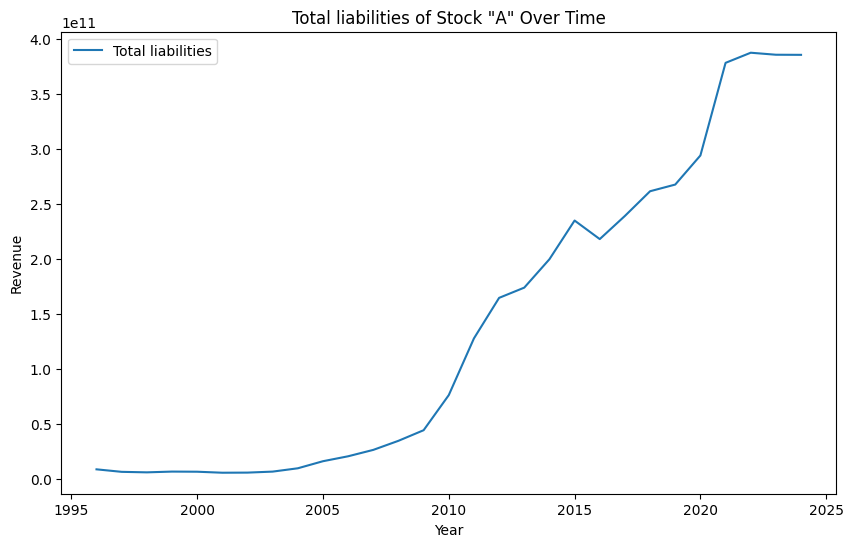

In [40]:
stock_data = df_annual[df_annual["Symbol"] == "AAPL"]

plt.figure(figsize=(10, 6))
plt.plot(stock_data['Year'], stock_data['Revenue'], label='Total liabilities')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.title('Total liabilities of Stock "A" Over Time')
plt.legend()
plt.show()

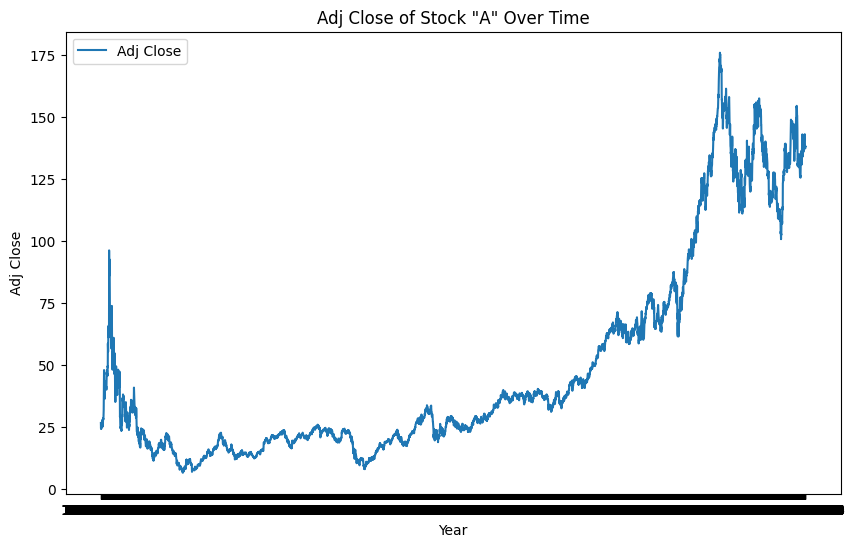

In [11]:
stock_data = df_final_cleaned[df_final_cleaned["Symbol"] == "A"]

plt.figure(figsize=(10, 6))
plt.plot(stock_data['Date'], stock_data['Adj Close'], label='Adj Close')
plt.xlabel('Year')
plt.ylabel('Adj Close')
plt.title('Adj Close of Stock "A" Over Time')
plt.legend()
plt.show()

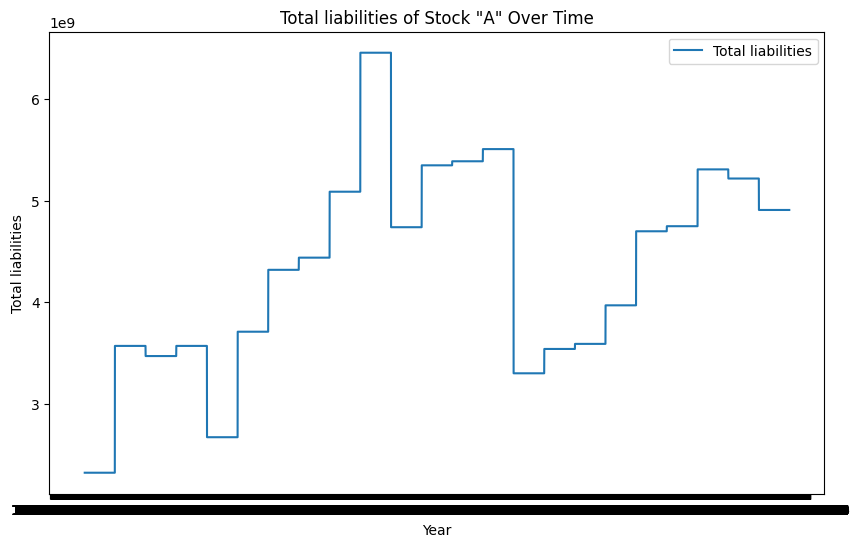

In [12]:
stock_data = df_final_cleaned[df_final_cleaned["Symbol"] == "A"]

plt.figure(figsize=(10, 6))
plt.plot(stock_data['Date'], stock_data['Total liabilities'], label='Total liabilities')
plt.xlabel('Year')
plt.ylabel('Total liabilities')
plt.title('Total liabilities of Stock "A" Over Time')
plt.legend()
plt.show()

In [ ]:



buttons = [2, 3, 5, 6, 7, 8, 11, 12, 15, 16, 17, 18, 19]

for button in buttons:
    
    if button < 6 and int:
        time.sleep(1)
        
        next_button = driver.find_element(By.XPATH, f'//*[@id="cmkt"]/div[3]/ul/li[{button}]/a')
        next_button.click()
        
        
    
    elif button == 6 and int:
        time.sleep(1)
        
        next_button = driver.find_element(By.XPATH, f'//*[@id="cmkt"]/div[3]/ul/li[{button}]/a')
        next_button.click()
        
        more_button = driver.find_element(By.XPATH, '//*[@id="cmkt"]/div[3]/ul/li[7]/a')
        more_button.click()
        
        next_button = driver.find_element(By.XPATH, '//*[@id="cmkt"]/div[3]/ul/li[7]/div/a[3]')
        next_button.click()
    
    else:
        time.sleep(1)
        more_variables = {7 : "Operating Margin", 8: "EPS", 11 : "Dividend yield", 12 : "Shares outstanding", 15 : "Total assets"
                        , 16 : "Total liabilities", 17 : "Total debt", 18 : "Cash on Hand", 19 : "Net Assets"}
        
        more_button = driver.find_element(By.LINK_TEXT, "More")
        more_button.click()
        
        
        next_button = driver.find_element(By.LINK_TEXT, more_variables[button])
        #next_button = driver.find_element(By.XPATH, '//*[@id="cmkt"]/div[3]/ul/li[8]/div/a[{new_button}]')
        next_button.click()

In [ ]:

def table_scrape(list_of_each_stock_sub_df):
    years = []
    stock_var = []

    first_table = driver.find_element(By.XPATH, '//*[@id="cmkt"]/div[3]/div[2]/div[3]')
    market_history = first_table.find_elements(By.TAG_NAME, 'tr')

    # Process the header row first
    header_row = market_history[0]
    header_elements = header_row.find_elements(By.TAG_NAME, 'th')

    # Extract header names
    headers = [element.text.strip() for element in header_elements[:2]]

    # Extract the data
    for row in market_history[1:]:
        # Find all <td> elements in the row
        elements = row.find_elements(By.TAG_NAME, 'td')

        year = elements[0].text.strip()
        var = elements[1].text.strip()

        years.append(year)
        stock_var.append(var)


    years = years[::-1]
    stock_var = stock_var[::-1]


    # Convert market cap values
    years_cap_numeric = [extract_year(year) for year in years]

    # Convert market cap values
    stock_var_numeric = [convert_value(var) for var in stock_var]

    # Create a data dictionary with cleaned data
    data = {
    headers[0]: years_cap_numeric,
    headers[1]: stock_var_numeric
    }

    # Create the DataFrame
    df = pd.DataFrame(data)
    list_of_each_stock_sub_df.append(df)

    time.sleep(0.5)

In [21]:
## We are scraping https://companiesmarketcap.com/

def webscrape_func(list_of_stocks):
    
    # Collection of each stocks dataframe
    global final_df
    final_df = []
    
    service = Service(executable_path="chromedriver.exe")
    driver = webdriver.Chrome(service=service)

    driver.get("https://companiesmarketcap.com/")

    
    
    for stock in list_of_stocks:

        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.ID, "search-input"))
        )

        input_element = driver.find_element(By.ID, "search-input")
        input_element.clear()
        input_element.send_keys(f"{stock}") # Insert stock symbol


        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.ID, "typeahead-search-results"))
        )
        search_stock = driver.find_element(By.ID, "typeahead-search-results")

        time.sleep(1)
        first_link = search_stock.find_element(By.TAG_NAME, 'a')
        first_link.click()
    
    
    
        ## Scrapes the table on a page
            
        # Initialize empty lists to store each dataframe
        total_df_each_stock = []

        button_list = [2, 3, 5, 6, 7]
        
        

        # These are the variables showcased on the site
        for button in button_list:
            # Initialize empty lists to store data
            years = []
            stock_var = []
            
            first_table = driver.find_element(By.XPATH, '//*[@id="cmkt"]/div[3]/div[2]/div[3]')
            market_history = first_table.find_elements(By.TAG_NAME, 'tr')

            # Process the header row first
            header_row = market_history[0]
            header_cells = header_row.find_elements(By.TAG_NAME, 'th')

            # Extract header names
            headers = [cell.text.strip() for cell in header_cells[:2]]

            # Extract the data
            for row in market_history[1:]:
                # Find all <td> elements in the row
                cells = row.find_elements(By.TAG_NAME, 'td')
                
                year = cells[0].text.strip()
                var = cells[1].text.strip()
                
                years.append(year)
                stock_var.append(var)
                
                
            years = years[::-1]
            stock_var = stock_var[::-1]


            # Convert market cap values
            years_cap_numeric = [extract_year(year) for year in years]
                
            # Convert market cap values
            stock_var_numeric = [convert_value(var) for var in stock_var]

            # Create a data dictionary with cleaned data
            data = {
                headers[0]: years_cap_numeric,
                headers[1]: stock_var_numeric
            }

            # Create the DataFrame
            df = pd.DataFrame(data)
            total_df_each_stock.append(df)
            
            time.sleep(0.5)
            
            next_button = driver.find_element(By.XPATH, f"//*[@id="cmkt"]/div[3]/ul/li['{button}']/a")

            next_button.click()
            
        
        # This is to load the first variable in "more"
        driver.find_element(By.XPATH, "//*[@id="cmkt"]/div[3]/ul/li[7]/div/a[3]").click()
       
       
        
        # These are the variables in the "more"-button
        
        more_button_list = [4, 5, 8, 9, 12, 13, 14, 15, 16]
        
        
                
        for button in more_button_list:
            # Initialize empty lists to store data
            years = []
            stock_var = []

            # Process the header row first
            header_row = market_history[0]
            header_cells = header_row.find_elements(By.TAG_NAME, 'th')

            # Extract header names
            headers = [cell.text.strip() for cell in header_cells[:2]]

            # Extract the data
            for row in market_history[2:]:
                # Find all <td> elements in the row
                cells = row.find_elements(By.TAG_NAME, 'td')
                
                year = cells[0].text.strip()
                var = cells[1].text.strip()
                
                years.append(year)
                stock_var.append(var)
                
                
            years = years[::-1]
            stock_var = stock_var[::-1]


            # Convert market cap values
            years_cap_numeric = [extract_year(year) for year in years]
                
            # Convert market cap values
            stock_var_numeric = [convert_value(var) for var in stock_var]

            # Create a data dictionary with cleaned data
            data = {
                headers[0]: years_cap_numeric,
                headers[1]: stock_var_numeric
            }

            # Create the DataFrame
            df = pd.DataFrame(data)
            total_df_each_stock.append(df)
            
            time.sleep(0.5)
            
            next_button = driver.find_element(By.XPATH, f"//*[@id="cmkt"]/div[3]/ul/li[8]/div/a['{button}']")

            next_button.click()
        
    
   

SyntaxError: invalid syntax (3848734346.py, line 97)

In [6]:
# Use the definition: market cap = stock price * shares outstanding, where we use the last adj close price of each year for the "N/A"-values.

df_final_cleaned['Date'] = pd.to_datetime(df_final_cleaned['Date'])

df_final_cleaned['Year'] = df_final_cleaned['Date'].dt.year

# Group by 'Symbol' and 'Year' and get the last 'Adj Close' of each year
last_adj_close = df_final_cleaned.groupby(['Symbol', 'Year'])['Adj Close'].last().reset_index()
last_adj_close.rename(columns={'Adj Close': 'Last Adj Close'}, inplace=True)

df_final_cleaned = pd.merge(df_final_cleaned, last_adj_close, on=['Symbol', 'Year'], how='left')

df_final_cleaned['Market capitalization'].fillna(df_final_cleaned['Shares Outstanding'] * df_final_cleaned['Last Adj Close'], inplace=True)

# Use the definition: shares outstanding = market cap / stock price.

df_final_cleaned['Shares Outstanding'].fillna(df_final_cleaned['Market capitalization'] / df_final_cleaned['Last Adj Close'], inplace=True)


# Use the definition: P/E ratio = market cap / earnings = stock price / EPS

df_final_cleaned['P/E ratio'].fillna(df_final_cleaned['Market capitalization'] / df_final_cleaned['Earnings'], inplace=True)

df_final_cleaned['P/E ratio'].fillna(df_final_cleaned['Last Adj Close'] / df_final_cleaned['EPS'], inplace=True)


df_final_cleaned['Market capitalization'].fillna(df_final_cleaned['P/E ratio'] * df_final_cleaned['Earnings'], inplace=True)

df_final_cleaned['Earnings'].fillna(df_final_cleaned['Market capitalization'] / df_final_cleaned['P/E ratio'], inplace=True)


df_final_cleaned['EPS'].fillna(df_final_cleaned['Last Adj Close'] / df_final_cleaned['P/E ratio'], inplace=True)


df_final_cleaned['Market capitalization'].fillna(df_final_cleaned['Last Adj Close'] * df_final_cleaned['Earnings'] / df_final_cleaned['EPS'], inplace=True)

df_final_cleaned['EPS'].fillna(df_final_cleaned['Last Adj Close'] * df_final_cleaned['Earnings'] / df_final_cleaned['Market capitalization'], inplace=True)

df_final_cleaned['Earnings'].fillna(df_final_cleaned['EPS'] * df_final_cleaned['Market capitalization'] / df_final_cleaned['Last Adj Close'], inplace=True)


df_final_cleaned.drop(columns=['Year', 'Last Adj Close'], inplace=True)

# df_final_cleaned.drop(columns=['Last Adj Close_x', 'Last Adj Close_y'], inplace=True)


# Use the definition: market cap = P/B ratio * Net assets

df_final_cleaned['Market capitalization'].fillna(df_final_cleaned['P/B ratio'] * df_final_cleaned['Net assets'], inplace=True)

df_final_cleaned['P/B ratio'].fillna(df_final_cleaned['Market capitalization'] / df_final_cleaned['Net assets'], inplace=True)

df_final_cleaned['Net assets'].fillna(df_final_cleaned['Market capitalization'] / df_final_cleaned['P/B ratio'], inplace=True)

# Use the definition: Net assets = Total assets - Total liabilities

df_final_cleaned['Net assets'].fillna(df_final_cleaned['Total assets'] - df_final_cleaned['Total liabilities'], inplace=True)

df_final_cleaned['Total liabilities'].fillna(df_final_cleaned['Total assets'] - df_final_cleaned['Net assets'], inplace=True)

df_final_cleaned['Total assets'].fillna(df_final_cleaned['Net assets'] + df_final_cleaned['Total liabilities'], inplace=True)


# Use the definition: Revenue = Earnings / Operating margin

df_final_cleaned['Revenue'].fillna(df_final_cleaned['Earnings'] / df_final_cleaned['Operating Margin'], inplace=True)

df_final_cleaned['Operating Margin'].fillna(df_final_cleaned['Earnings'] / df_final_cleaned['Revenue'], inplace=True)

df_final_cleaned['Earnings'].fillna(df_final_cleaned['Operating Margin'] * df_final_cleaned['Revenue'], inplace=True)

# Use the definition: EPS = Earnings / Shares Outstanding

df_final_cleaned['EPS'].fillna(df_final_cleaned['Earnings'] / df_final_cleaned['Shares Outstanding'], inplace=True)

df_final_cleaned['Shares Outstanding'].fillna(df_final_cleaned['Earnings'] / df_final_cleaned['EPS'], inplace=True)

df_final_cleaned['Earnings'].fillna(df_final_cleaned['Shares Outstanding'] * df_final_cleaned['EPS'], inplace=True)
